# Hourly Energy Consumption.
![energy](energy.jpg)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime, timedelta

color_pal = sns.color_palette()

In [222]:
pjm_data = pd.read_csv('data/pjm_hourly_est.csv')
pjm_data['Datetime'] = pd.to_datetime(pjm_data['Datetime'])
pjm_data = pjm_data.set_index('Datetime')

In [223]:
missing_values = pjm_data.isnull().sum()
print("Giá trị thiếu trong mỗi cột:\n", missing_values)
missing_percentage = (missing_values / len(pjm_data)) * 100
print("\nPhần trăm giá trị thiếu trong mỗi cột:")
for column, percentage in missing_percentage.items():
    print(f"{column}: {percentage:.2f}%")

Giá trị thiếu trong mỗi cột:
 AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

Phần trăm giá trị thiếu trong mỗi cột:
AEP: 31.97%
COMED: 62.70%
DAYTON: 31.97%
DEOK: 67.61%
DOM: 34.82%
DUQ: 33.21%
EKPC: 74.57%
FE: 64.73%
NI: 67.21%
PJME: 18.45%
PJMW: 19.67%
PJM_Load: 81.55%


Focusing on PJME or PJMW

In [6]:
PJME_df_origin = pd.read_csv('data/PJME_hourly.csv')
PJME_df = PJME_df_origin.copy()
PJME_df['Datetime'] = pd.to_datetime(PJME_df['Datetime'])

In [7]:
PJME_df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [8]:
PJME_df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [9]:
PJME_df.describe()

,Datetime,PJME_MW
count,145366,145366.000000
mean,2010-04-18 03:25:25.999202048,32080.222831
min,2002-01-01 01:00:00,14544.000000
25%,2006-02-23 14:15:00,27573.000000
50%,2010-04-18 04:30:00,31421.000000
75%,2014-06-10 18:45:00,35650.000000
max,2018-08-03 00:00:00,62009.000000
std,NaN,6464.012166


Cột trùng

In [10]:
print("Check of Duplicates:")
print(f"{PJME_df[PJME_df.duplicated()]}")

print("Check of Duplicates (Datetimes):")
print(f"{PJME_df[PJME_df['Datetime'].duplicated()]}")

Check of Duplicates:
Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []
Check of Duplicates (Datetimes):
                  Datetime  PJME_MW
106585 2014-11-02 02:00:00  23755.0
115369 2015-11-01 02:00:00  21171.0
124009 2016-11-06 02:00:00  21692.0
132817 2017-11-05 02:00:00  20666.0


Cột thiếu

In [11]:
missing_dates = pd.date_range(start=pd.to_datetime('2002-01-01 01:00:00'), 
                              end=pd.to_datetime('2018-08-03 00:00:00'), 
                              freq='h').difference(PJME_df['Datetime'])
missing_dates

DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [12]:
PJME_df = PJME_df.set_index('Datetime')

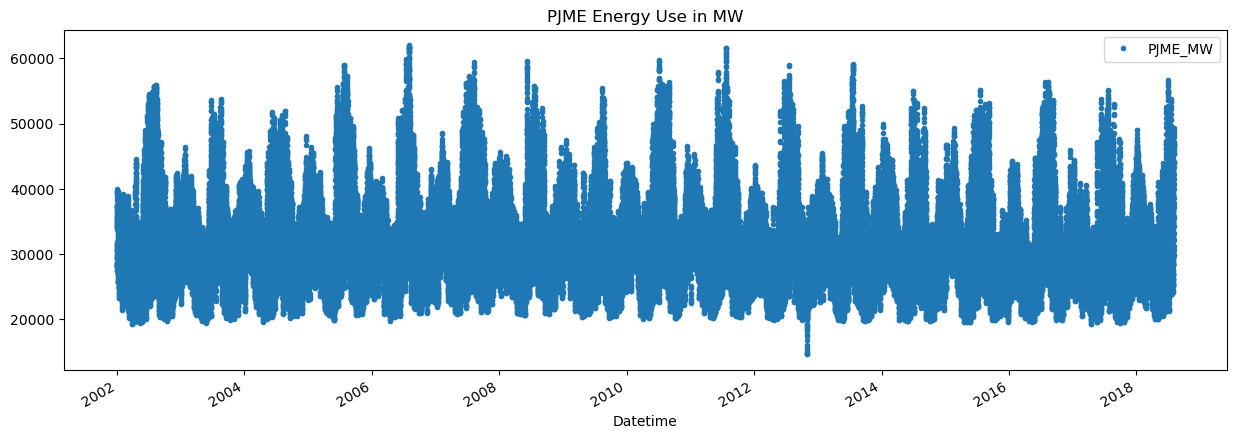

In [176]:
PJME_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Seasonal Pattern plus Linear Growth

Text(0.5, 1.0, 'Box plot PJME')

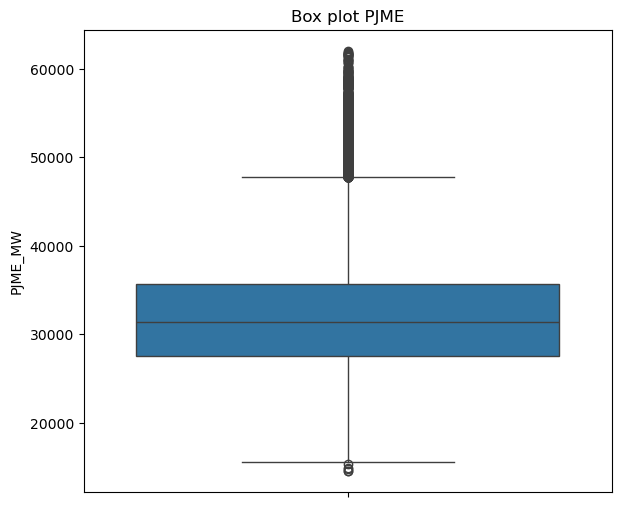

In [11]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y='PJME_MW', data=PJME_df)
plt.title('Box plot PJME')

### Feature creation


In [13]:
def create_features_Datetime(PJME_df):

  PJME_df['Year'] = PJME_df.index.year
  PJME_df['Quarter'] = PJME_df.index.quarter
  PJME_df['Month'] = PJME_df.index.month
  PJME_df['Day'] = PJME_df.index.day
  PJME_df['Hour'] = PJME_df.index.hour

  PJME_df['Day_of_Year'] = PJME_df.index.dayofyear

  PJME_df['Weekday'] = PJME_df.index.weekday
  PJME_df['Is_Weekend'] = PJME_df['Weekday'].isin([5, 6]).astype(int)

  PJME_df['Season'] = PJME_df['Month'].apply(lambda x: 
                                                         1 if (x >= 3 and x <= 5) else  # Xuân
                                                         2 if (x >= 6 and x <= 8) else  # Hạ
                                                         3 if (x >= 9 and x <= 11) else  # Thu
                                                         4) # Đông

  return PJME_df

In [14]:
PJME_df.pipe(create_features_Datetime).head()


,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,12,31,1,365,1,0,4
2002-12-31 02:00:00,25147.0,2002,4,12,31,2,365,1,0,4
2002-12-31 03:00:00,24574.0,2002,4,12,31,3,365,1,0,4
2002-12-31 04:00:00,24393.0,2002,4,12,31,4,365,1,0,4
2002-12-31 05:00:00,24860.0,2002,4,12,31,5,365,1,0,4


outliers

Text(0.5, 1.0, 'PJME_MW by Weekday')

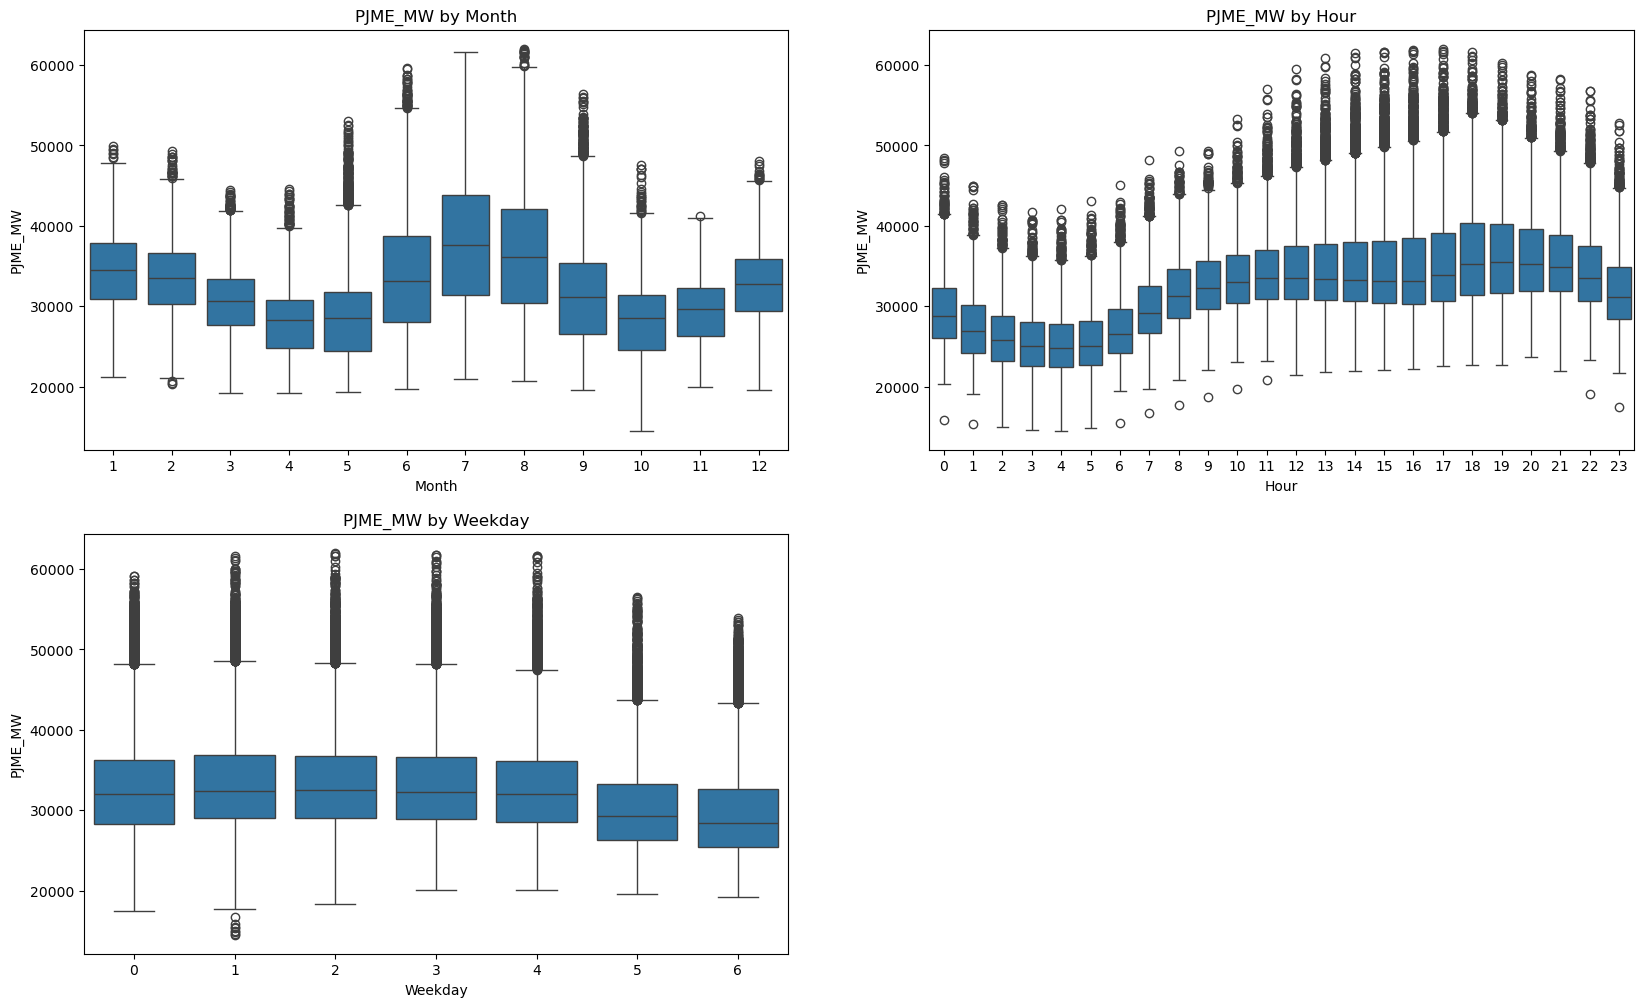

In [29]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.boxplot(data=PJME_df, y='PJME_MW', x='Month')
plt.title('PJME_MW by Month')

plt.subplot(2,2,2)
sns.boxplot(data=PJME_df, y='PJME_MW', x='Hour')
plt.title('PJME_MW by Hour')

plt.subplot(2,2,3)
sns.boxplot(data=PJME_df, y='PJME_MW', x='Weekday')
plt.title('PJME_MW by Weekday')

Text(0.5, 1.0, 'PJME_MW by Season')

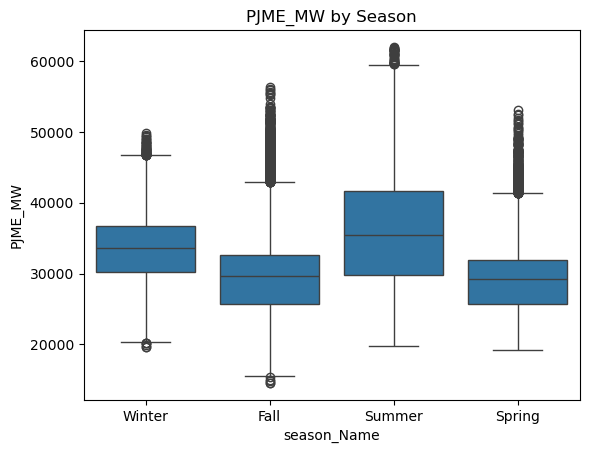

In [32]:
sns.boxplot(data=PJME_df, y="PJME_MW", x='season_Name')
plt.title('PJME_MW by Season')

In [1]:
from statsmodels.graphics.tsaplots import plot_acf

Biểu đồ tương quan

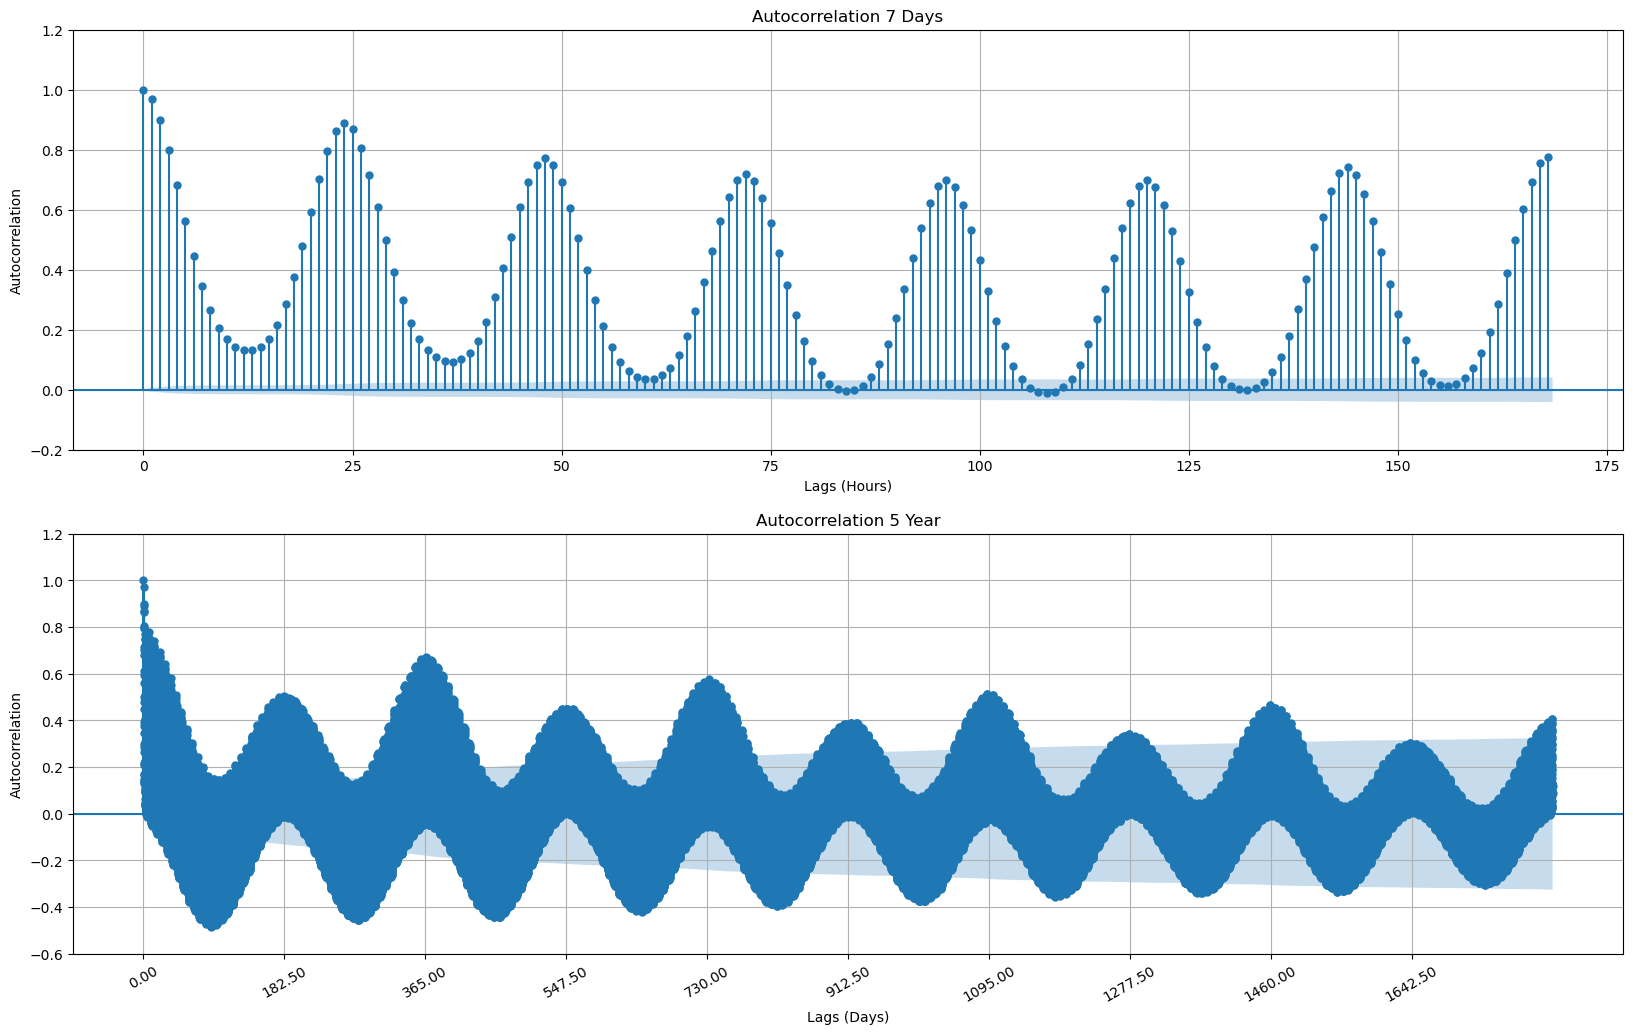

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

plot_acf(PJME_df['PJME_MW'], lags=24*7, ax=ax[0])

ax[0].set_title('Autocorrelation 7 Days')
ax[0].set_xlabel('Lags (Hours)')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_ylim(-0.2, 1.2)
ax[0].grid(True)

plot_acf(PJME_df['PJME_MW'], lags=24*365*5, ax=ax[1])

ax[1].set_title('Autocorrelation 5 Year')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_ylim(-0.6, 1.2)

ax[1].set_xlabel('Lags (Days)')

hours_featured = [i for i in range(0, 5*365*24, 365*12)]
ax[1].set_xticks(hours_featured)

days_featured =  [f"{hour/(24):.2f}" for hour in hours_featured]
ax[1].set_xticklabels(days_featured, rotation=30)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax[1].grid(True)

Kiểm tra tính dừng của mô hình

In [18]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_PJME_ts['PJME_MW'])
test_statistic, p_value, _, _, _, _ = adf_result

print(f'ADF Statistic: {test_statistic}')
print(f'P-value: {p_value}')

if p_value <= 0.05:
	print('Reject the null hypothesis: The time series is Stationary.')
else:
	print('Fail to reject the null hypothesis: The time series is Non-Stationary.')

ADF Statistic: -19.964593931840863
P-value: 0.0
Reject the null hypothesis: The time series is Stationary.


### Handle missing values

In [15]:
df_PJME_ts_raw = PJME_df_origin.copy()
df_PJME_ts_raw['Datetime'] = pd.to_datetime(df_PJME_ts_raw['Datetime'])

df_PJME_ts = df_PJME_ts_raw.copy()

df_PJME_ts = df_PJME_ts.set_index('Datetime').sort_index()
df_PJME_ts = df_PJME_ts.resample('h').mean()

df_PJME_ts['PJME_MW'] = df_PJME_ts['PJME_MW'].interpolate(method='time')

df_PJME_ts.pipe(create_features_Datetime).head()

,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,0,4
2002-01-01 02:00:00,29265.0,2002,1,1,1,2,1,1,0,4
2002-01-01 03:00:00,28357.0,2002,1,1,1,3,1,1,0,4
2002-01-01 04:00:00,27899.0,2002,1,1,1,4,1,1,0,4
2002-01-01 05:00:00,28057.0,2002,1,1,1,5,1,1,0,4


In [16]:
df_PJME_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PJME_MW      145392 non-null  float64
 1   Year         145392 non-null  int32  
 2   Quarter      145392 non-null  int32  
 3   Month        145392 non-null  int32  
 4   Day          145392 non-null  int32  
 5   Hour         145392 non-null  int32  
 6   Day_of_Year  145392 non-null  int32  
 7   Weekday      145392 non-null  int32  
 8   Is_Weekend   145392 non-null  int64  
 9   Season       145392 non-null  int64  
dtypes: float64(1), int32(7), int64(2)
memory usage: 8.3 MB


# Training/testing split


In [186]:
from sklearn.model_selection import train_test_split

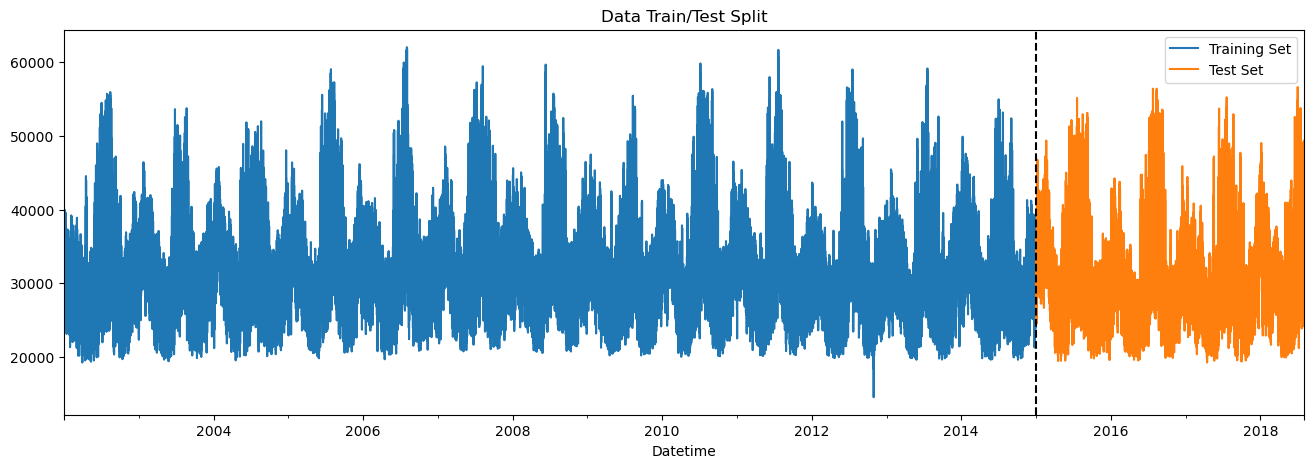

In [200]:
train = df_PJME_ts.loc[df_PJME_ts.index < '01-01-2015'].copy()
test = df_PJME_ts.loc[df_PJME_ts.index >= '01-01-2015'].copy()
fig, ax = plt.subplots(figsize=(16, 5))
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [201]:
train = create_features_Datetime(train)
test = create_features_Datetime(test)

FEATURES = ['Day_of_Year', 'Hour', 'Weekday', 'Quarter', 'Month', 'Year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [202]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32603.50613	validation_1-rmse:31657.42430
[100]	validation_0-rmse:12580.56894	validation_1-rmse:11742.95563


/opt/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:21:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:5837.98773	validation_1-rmse:5365.82763
[300]	validation_0-rmse:3925.89160	validation_1-rmse:4020.84427
[400]	validation_0-rmse:3448.54976	validation_1-rmse:3861.35063
[500]	validation_0-rmse:3289.79649	validation_1-rmse:3816.33147
[600]	validation_0-rmse:3207.88488	validation_1-rmse:3776.74993
[700]	validation_0-rmse:3153.29527	validation_1-rmse:3756.39433
[800]	validation_0-rmse:3114.25136	validation_1-rmse:3738.25611
[900]	validation_0-rmse:3084.66276	validation_1-rmse:3729.58268
[999]	validation_0-rmse:3058.15989	validation_1-rmse:3727.13986


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature importance

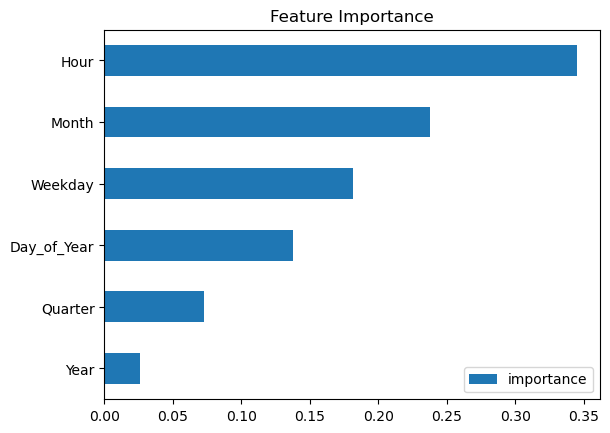

In [203]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

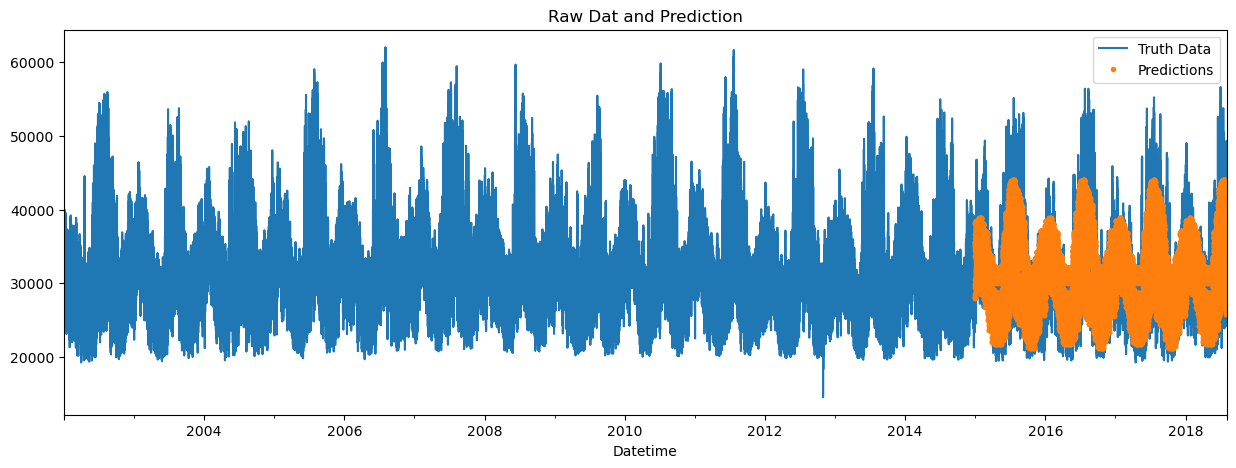

In [212]:
test['prediction'] = reg.predict(X_test)
df_PJME_ts = df_PJME_ts.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_PJME_ts[['PJME_MW']].plot(figsize=(15, 5))
df_PJME_ts['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Ver 2


In [19]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

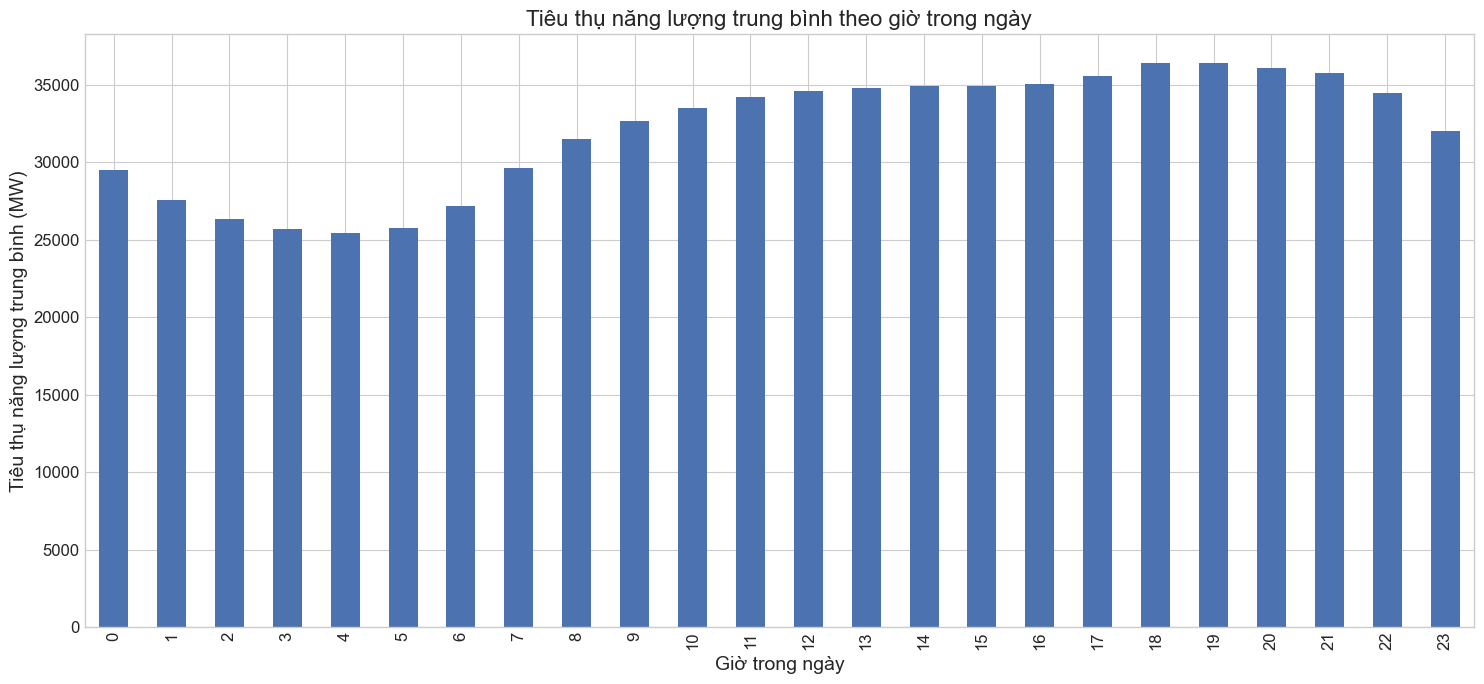

In [22]:
plt.figure(figsize=(15, 7))
hourly_avg = PJME_df.groupby('Hour')['PJME_MW'].mean()
hourly_avg.plot(kind='bar')
plt.title('Tiêu thụ năng lượng trung bình theo giờ trong ngày', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Giờ trong ngày', fontsize=14)
plt.tight_layout()

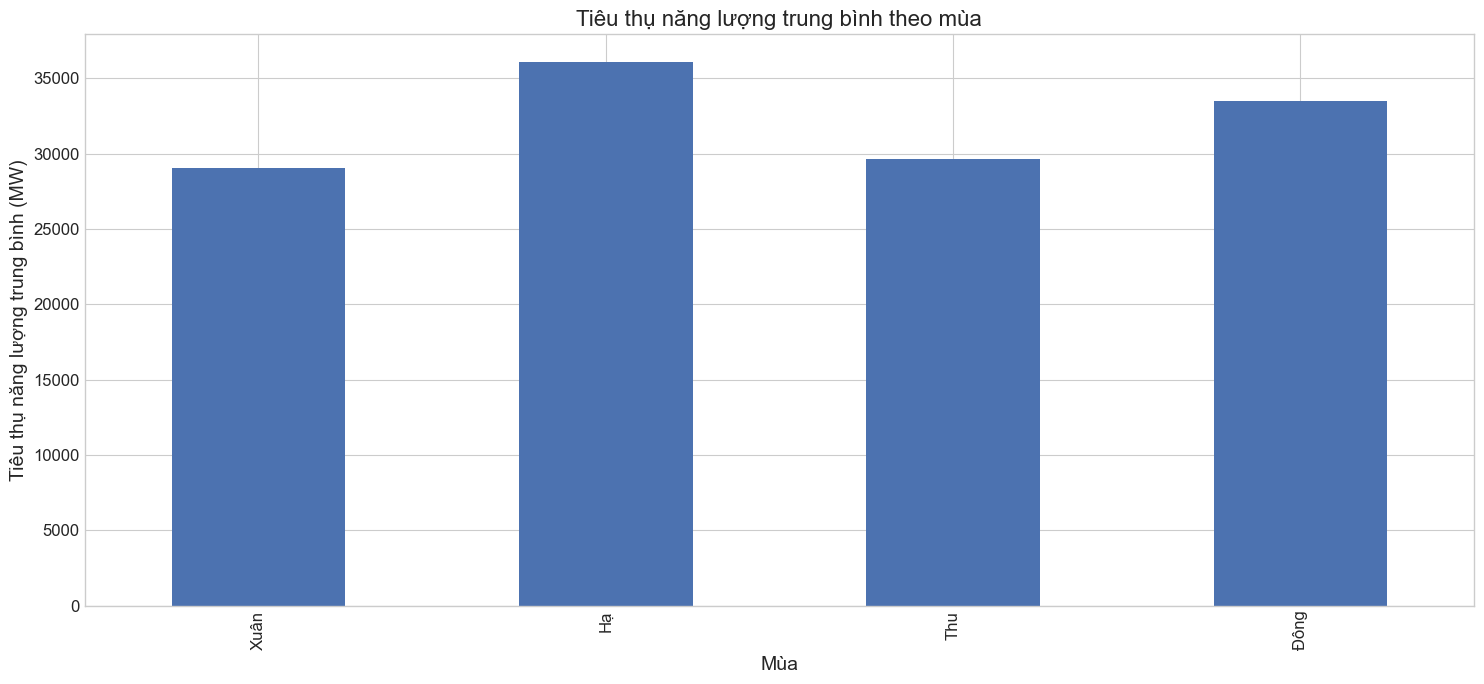

In [23]:
plt.figure(figsize=(15, 7))
season_names = ['Xuân', 'Hạ', 'Thu', 'Đông']
season_avg = PJME_df.groupby('Season')['PJME_MW'].mean()
season_avg.index = season_names
season_avg.plot(kind='bar')
plt.title('Tiêu thụ năng lượng trung bình theo mùa', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Mùa', fontsize=14)
plt.tight_layout()

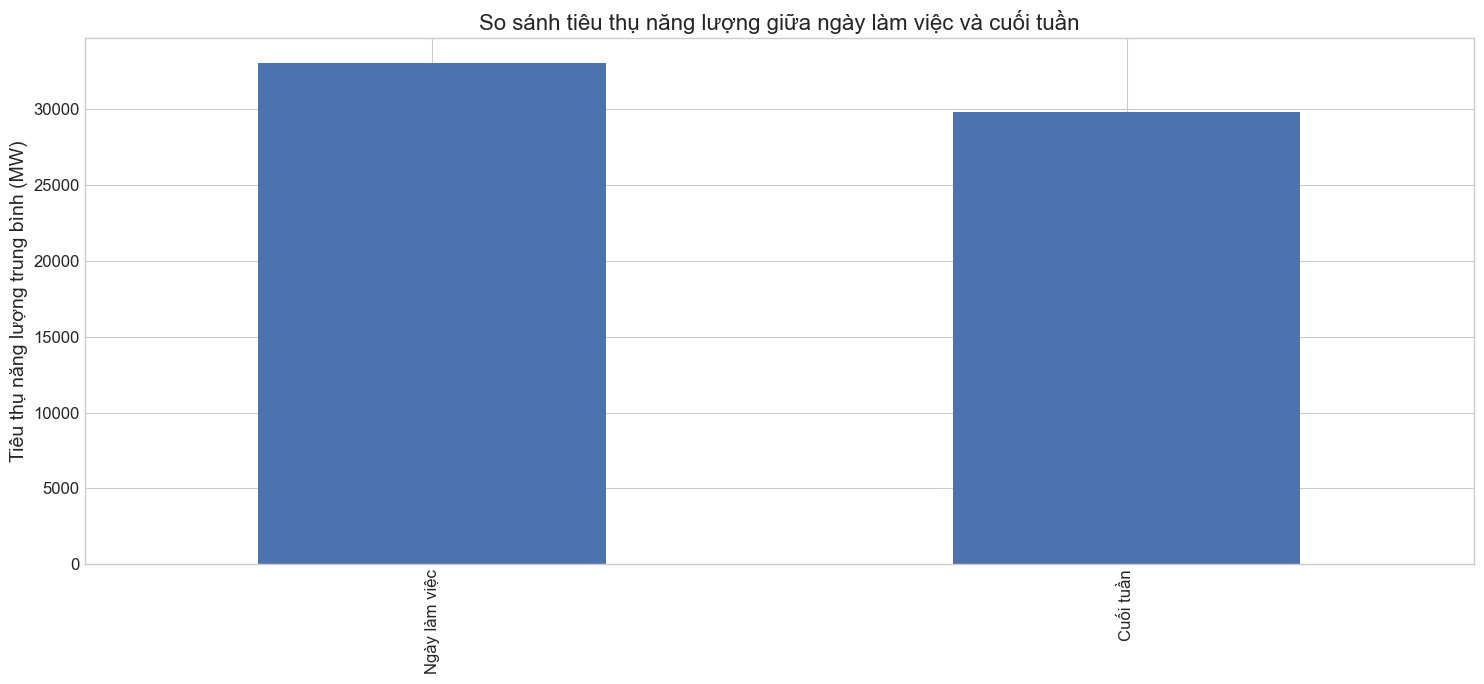

In [25]:
plt.figure(figsize=(15, 7))
weekend_status = ['Ngày làm việc', 'Cuối tuần']
weekend_avg = PJME_df.groupby('Is_Weekend')['PJME_MW'].mean()
weekend_avg.index = weekend_status
weekend_avg.plot(kind='bar')
plt.title('So sánh tiêu thụ năng lượng giữa ngày làm việc và cuối tuần', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('', fontsize=14)
plt.tight_layout()

<Figure size 1600x1000 with 0 Axes>

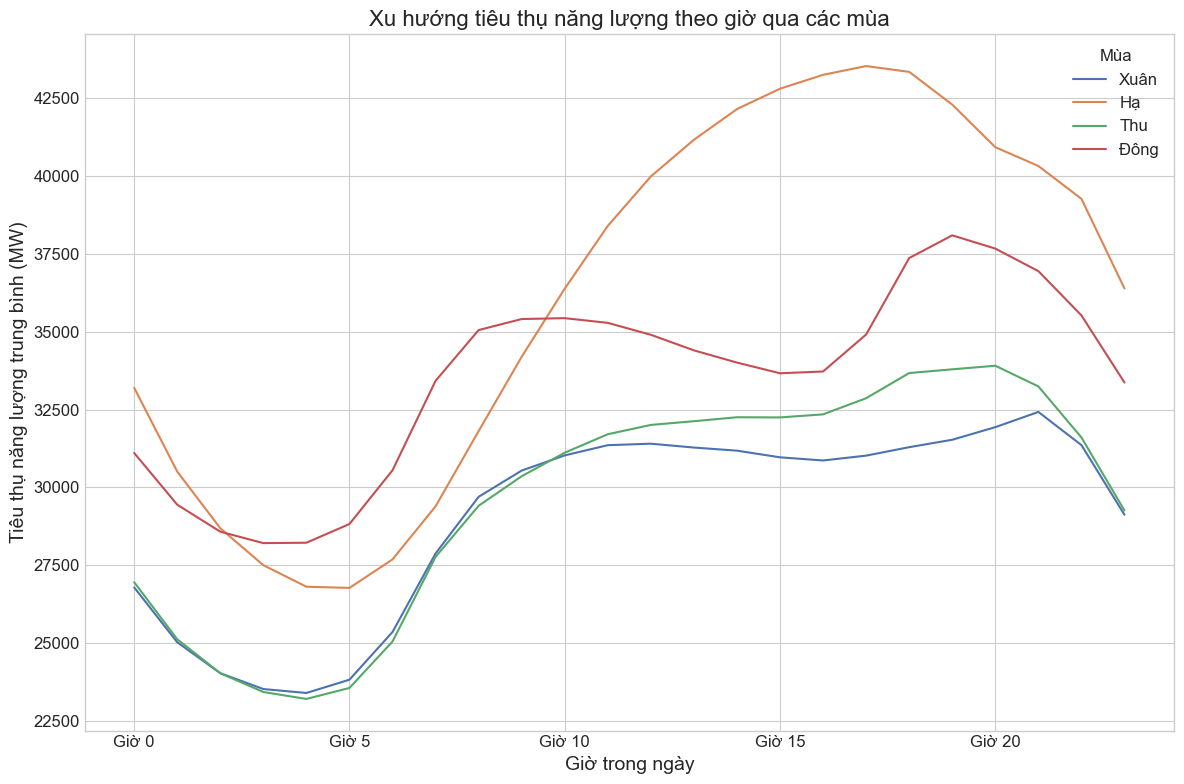

In [26]:
plt.figure(figsize=(16, 10))
season_hour_avg = PJME_df.groupby(['Season', 'Hour'])['PJME_MW'].mean().unstack()
season_hour_avg.columns = [f'Giờ {hour}' for hour in range(24)]
season_hour_avg.index = ['Xuân', 'Hạ', 'Thu', 'Đông']
season_hour_avg.T.plot()
plt.title('Xu hướng tiêu thụ năng lượng theo giờ qua các mùa', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Giờ trong ngày', fontsize=14)
plt.legend(title='Mùa')
plt.tight_layout()

Tránh sử dụng các biến gây đa cộng tuyến

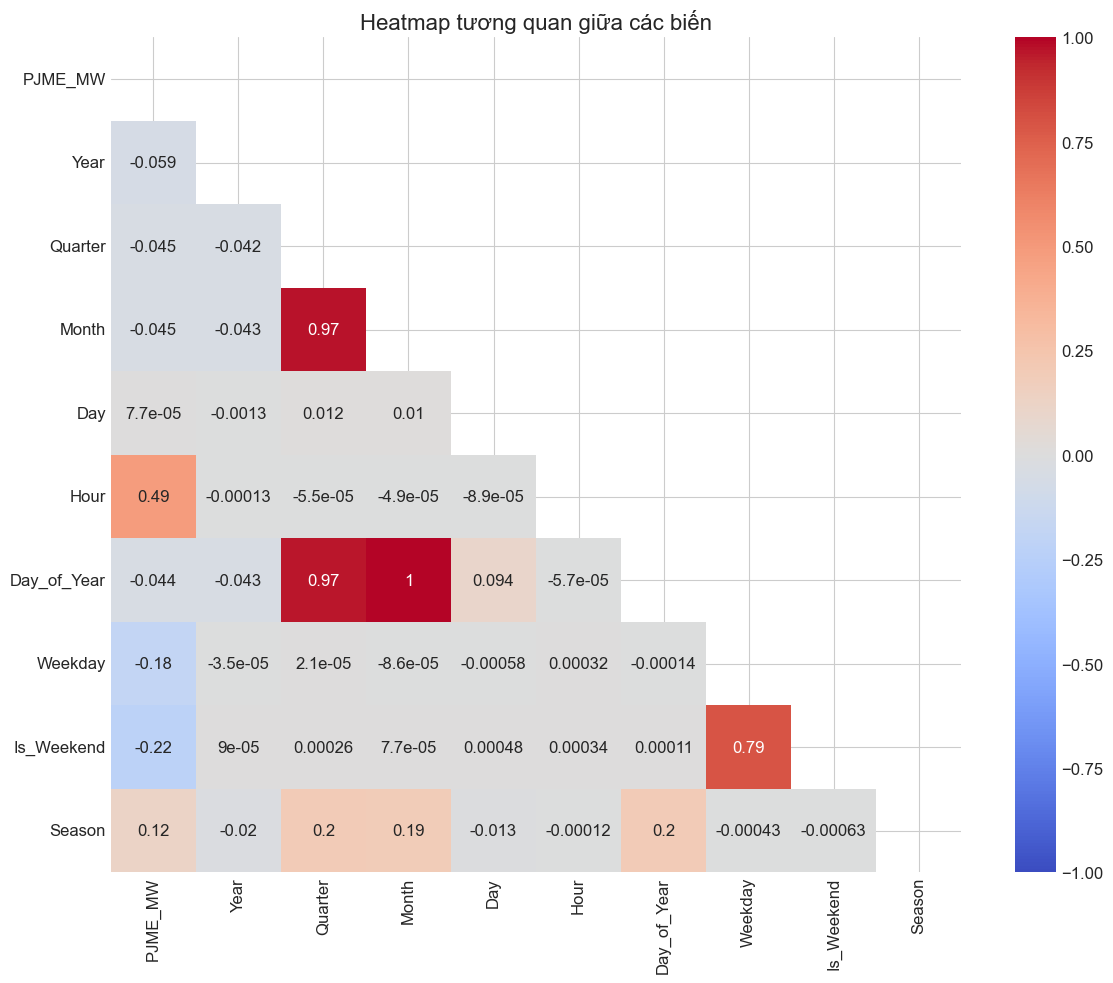

In [27]:
plt.figure(figsize=(12, 10))
correlation = PJME_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Heatmap tương quan giữa các biến', fontsize=16)
plt.tight_layout()

In [28]:
last_year = df_PJME_ts['Year'].max()
train_data = df_PJME_ts[df_PJME_ts['Year'] < last_year]
test_data = df_PJME_ts[df_PJME_ts['Year'] == last_year]

print(f"Chia dữ liệu thành tập huấn luyện ({train_data.shape[0]} mẫu) và tập kiểm tra ({test_data.shape[0]} mẫu)")

Chia dữ liệu thành tập huấn luyện (140255 mẫu) và tập kiểm tra (5137 mẫu)


In [54]:
feature_columns = ['Hour', 'Weekday', 'Month', 'Season']
X_train = train_data[feature_columns]
y_train = train_data['PJME_MW']
X_test = test_data[feature_columns]
y_test = test_data['PJME_MW']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [55]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [56]:
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}")

Random Forest - MAE: 2924.07, RMSE: 3772.04, R²: 0.6391


In [57]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [58]:
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")

XGBoost - MAE: 2929.71, RMSE: 3775.46, R²: 0.6385


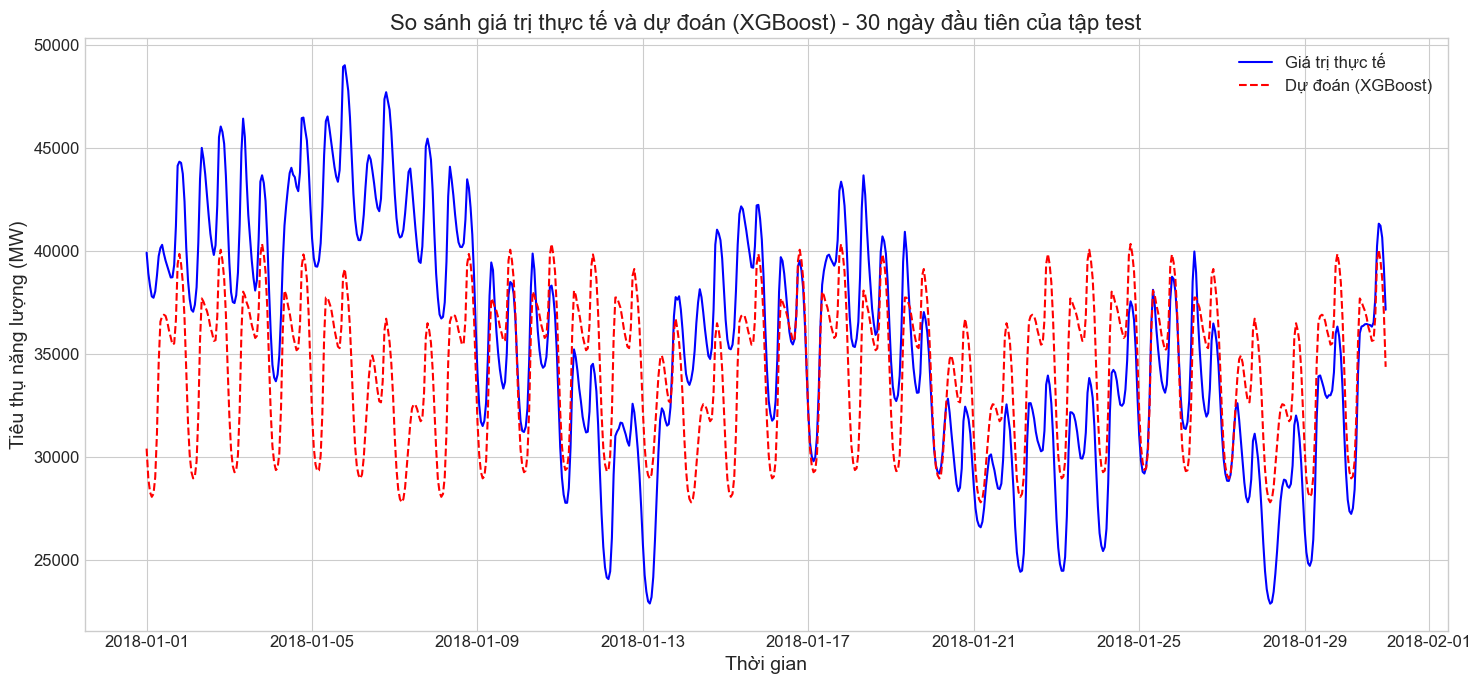

In [59]:
plt.figure(figsize=(15, 7))
# Lấy 30 ngày đầu tiên của tập test để trực quan hóa
test_sample = test_data.iloc[:30*24]
test_sample_predictions = xgb_predictions[:30*24] if xgb_mae < rf_mae else rf_predictions[:30*24]
model_name = "XGBoost" if xgb_mae > rf_mae else "Random Forest"

plt.plot(test_sample.index, test_sample['PJME_MW'], label='Giá trị thực tế', color='blue')
plt.plot(test_sample.index, test_sample_predictions, label=f'Dự đoán ({model_name})', color='red', linestyle='--')
plt.title(f'So sánh giá trị thực tế và dự đoán ({model_name}) - 30 ngày đầu tiên của tập test', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng (MW)', fontsize=14)
plt.xlabel('Thời gian', fontsize=14)
plt.legend()
plt.tight_layout()

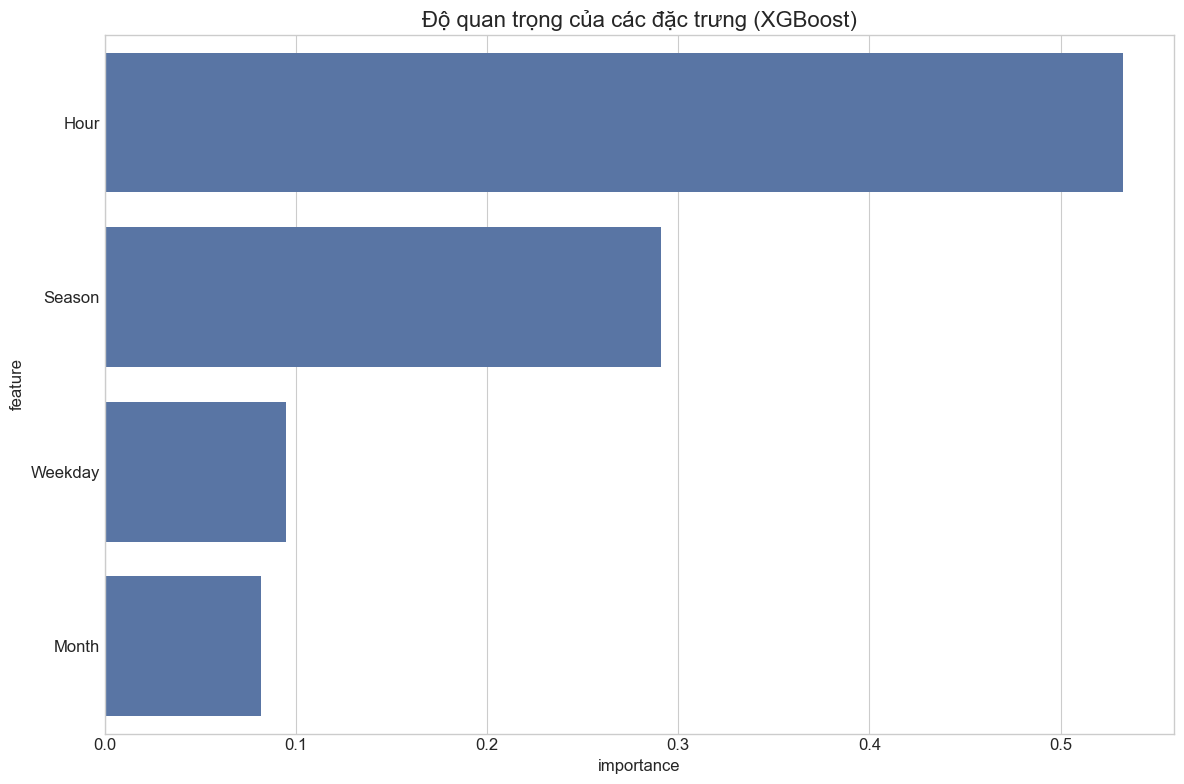

In [60]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_ if xgb_mae < rf_mae else rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title(f'Độ quan trọng của các đặc trưng ({model_name})', fontsize=16)
plt.tight_layout()

# Ver3

In [61]:
features_enhanced = df_PJME_ts.copy()

In [62]:
for lag in [1, 24, 48, 72, 168]: 
    features_enhanced[f'lag_{lag}h'] = features_enhanced['PJME_MW'].shift(lag)

for window in [24, 168]: 
    features_enhanced[f'rolling_mean_{window}h'] = features_enhanced['PJME_MW'].rolling(window=window).mean()
    features_enhanced[f'rolling_std_{window}h'] = features_enhanced['PJME_MW'].rolling(window=window).std()
    features_enhanced[f'rolling_min_{window}h'] = features_enhanced['PJME_MW'].rolling(window=window).min()
    features_enhanced[f'rolling_max_{window}h'] = features_enhanced['PJME_MW'].rolling(window=window).max()

In [63]:
features_enhanced['diff_1h'] = features_enhanced['PJME_MW'].diff(1)
features_enhanced['diff_24h'] = features_enhanced['PJME_MW'].diff(24)

In [80]:
features_enhanced.tail(5)

,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season,...,rolling_mean_24h,rolling_std_24h,rolling_min_24h,rolling_max_24h,rolling_mean_168h,rolling_std_168h,rolling_min_168h,rolling_max_168h,diff_1h,diff_24h
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,2018,3,8,2,20,214,3,0,2,...,39902.916667,6368.579836,29791.0,47154.0,35900.238095,6755.525713,24161.0,49308.0,-1584.0,-2855.0
2018-08-02 21:00:00,43256.0,2018,3,8,2,21,214,3,0,2,...,39789.208333,6278.997878,29791.0,47154.0,35892.583333,6746.397424,24161.0,49308.0,-801.0,-2729.0
2018-08-02 22:00:00,41552.0,2018,3,8,2,22,214,3,0,2,...,39683.291667,6224.428358,29791.0,47154.0,35886.119048,6740.413014,24161.0,49308.0,-1704.0,-2542.0
2018-08-02 23:00:00,38500.0,2018,3,8,2,23,214,3,0,2,...,39593.041667,6225.262959,29791.0,47154.0,35881.500000,6738.341667,24161.0,49308.0,-3052.0,-2166.0
2018-08-03 00:00:00,35486.0,2018,3,8,3,0,215,4,0,2,...,39523.375000,6262.939842,29791.0,47154.0,35879.976190,6738.402348,24161.0,49308.0,-3014.0,-1672.0


In [66]:
print(features_enhanced.isna().sum())

PJME_MW                0
Year                   0
Quarter                0
Month                  0
Day                    0
Hour                   0
Day_of_Year            0
Weekday                0
Is_Weekend             0
Season                 0
lag_1h                 1
lag_24h               24
lag_48h               48
lag_72h               72
lag_168h             168
rolling_mean_24h      23
rolling_std_24h       23
rolling_min_24h       23
rolling_max_24h       23
rolling_mean_168h    167
rolling_std_168h     167
rolling_min_168h     167
rolling_max_168h     167
diff_1h                1
diff_24h              24
dtype: int64


In [67]:
features_enhanced_filled = features_enhanced.copy()

for col in features_enhanced.columns:
    if col.startswith('lag_'):
        features_enhanced_filled[col] = features_enhanced.groupby(features_enhanced.index.hour)[col].transform(
            lambda x: x.fillna(x.mean())
        )

for window in [24, 168]: 
    mask = features_enhanced_filled[f'rolling_mean_{window}h'].isna()
    features_enhanced_filled.loc[mask, f'rolling_mean_{window}h'] = features_enhanced_filled.loc[mask, 'PJME_MW']
    
    features_enhanced_filled[f'rolling_std_{window}h'] = features_enhanced_filled[f'rolling_std_{window}h'].fillna(0)
    
    features_enhanced_filled.loc[mask, f'rolling_min_{window}h'] = features_enhanced_filled.loc[mask, 'PJME_MW']
    features_enhanced_filled.loc[mask, f'rolling_max_{window}h'] = features_enhanced_filled.loc[mask, 'PJME_MW']

features_enhanced_filled['diff_1h'] = features_enhanced_filled['diff_1h'].fillna(0)
features_enhanced_filled['diff_24h'] = features_enhanced_filled['diff_24h'].fillna(0)

In [68]:
print(features_enhanced_filled.isna().sum())

PJME_MW              0
Year                 0
Quarter              0
Month                0
Day                  0
Hour                 0
Day_of_Year          0
Weekday              0
Is_Weekend           0
Season               0
lag_1h               0
lag_24h              0
lag_48h              0
lag_72h              0
lag_168h             0
rolling_mean_24h     0
rolling_std_24h      0
rolling_min_24h      0
rolling_max_24h      0
rolling_mean_168h    0
rolling_std_168h     0
rolling_min_168h     0
rolling_max_168h     0
diff_1h              0
diff_24h             0
dtype: int64


In [70]:
last_year = features_enhanced['Year'].max()
train_data = features_enhanced[features_enhanced['Year'] < last_year]
test_data = features_enhanced[features_enhanced['Year'] == last_year]

print(f"Chia dữ liệu thành tập huấn luyện ({train_data.shape[0]} mẫu) và tập kiểm tra ({test_data.shape[0]} mẫu)")

Chia dữ liệu thành tập huấn luyện (140255 mẫu) và tập kiểm tra (5137 mẫu)


In [71]:
feature_columns = ['Hour', 'Weekday', 'Month', 'Season', 'lag_1h', 'lag_24h', 'lag_48h','rolling_mean_24h', 'diff_1h', 'diff_24h']
X_train = train_data[feature_columns]
y_train = train_data['PJME_MW']
X_test = test_data[feature_columns]
y_test = test_data['PJME_MW']

In [72]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [73]:
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")

XGBoost - MAE: 46.80, RMSE: 96.73, R²: 0.9998


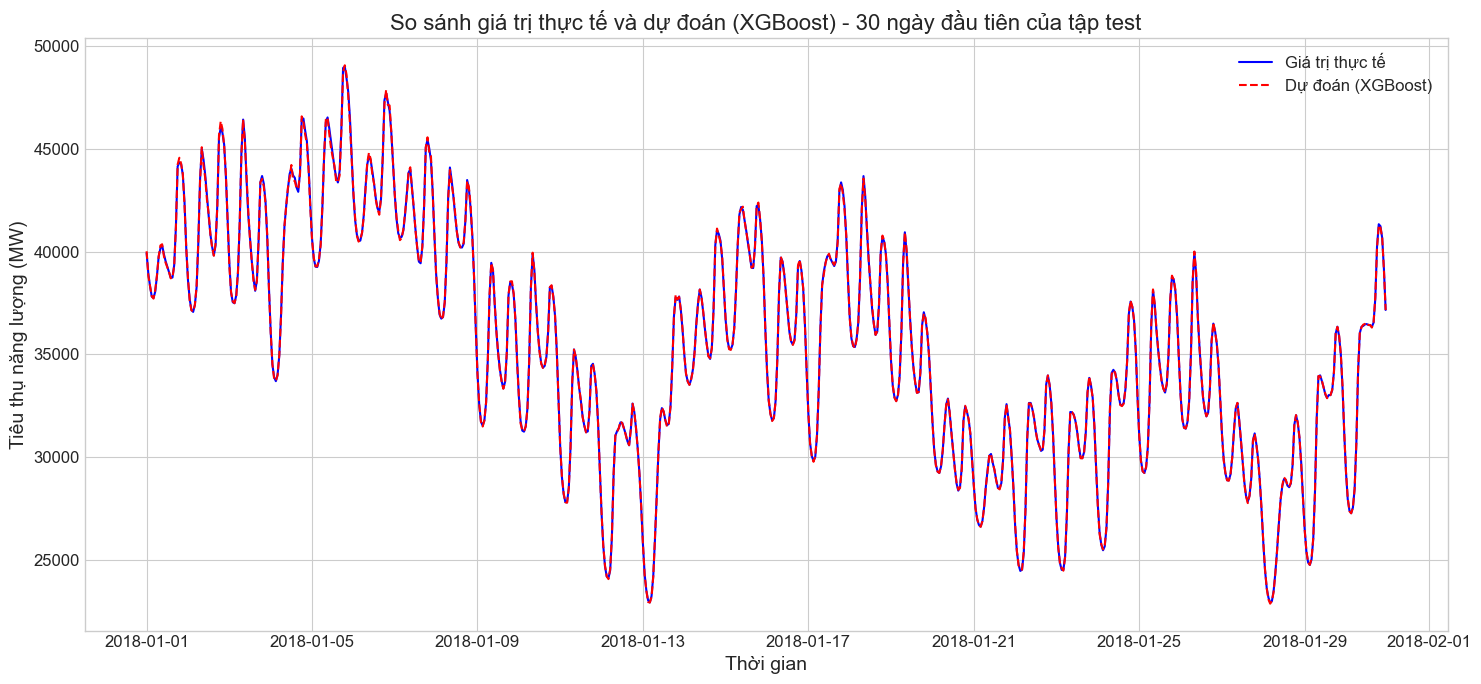

In [74]:
plt.figure(figsize=(15, 7))
test_sample = test_data.iloc[:30*24]
test_sample_predictions = xgb_predictions[:30*24]
model_name = "XGBoost"

plt.plot(test_sample.index, test_sample['PJME_MW'], label='Giá trị thực tế', color='blue')
plt.plot(test_sample.index, test_sample_predictions, label=f'Dự đoán ({model_name})', color='red', linestyle='--')
plt.title(f'So sánh giá trị thực tế và dự đoán ({model_name}) - 30 ngày đầu tiên của tập test', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng (MW)', fontsize=14)
plt.xlabel('Thời gian', fontsize=14)
plt.legend()
plt.tight_layout()